In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.utils import compute_class_weight
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Load data

In [2]:
df = pd.read_csv("seattle-weather.csv",index_col="date",parse_dates=True)
df.index.freq = "D"

In [3]:
df.head()

,precipitation,temp_max,temp_min,wind,weather
date,,,,,
2012-01-01,0.0,12.8,5.0,4.7,drizzle
2012-01-02,10.9,10.6,2.8,4.5,rain
2012-01-03,0.8,11.7,7.2,2.3,rain
2012-01-04,20.3,12.2,5.6,4.7,rain
2012-01-05,1.3,8.9,2.8,6.1,rain


## Add features

In [4]:
df["year"] = df.index.year
df["month"] = df.index.month
df["day"] = df.index.day
df["day_of_year"] = df.index.day_of_year
df["quarter"] = df.index.quarter

In [5]:
df

,precipitation,temp_max,temp_min,wind,weather,year,month,day,day_of_year,quarter
date,,,,,,,,,,
2012-01-01,0.0,12.8,5.0,4.7,drizzle,2012,1,1,1,1
2012-01-02,10.9,10.6,2.8,4.5,rain,2012,1,2,2,1
2012-01-03,0.8,11.7,7.2,2.3,rain,2012,1,3,3,1
2012-01-04,20.3,12.2,5.6,4.7,rain,2012,1,4,4,1
2012-01-05,1.3,8.9,2.8,6.1,rain,2012,1,5,5,1
...,...,...,...,...,...,...,...,...,...,...
2015-12-27,8.6,4.4,1.7,2.9,rain,2015,12,27,361,4
2015-12-28,1.5,5.0,1.7,1.3,rain,2015,12,28,362,4
2015-12-29,0.0,7.2,0.6,2.6,fog,2015,12,29,363,4


## Countplot - Check for imbalanced data

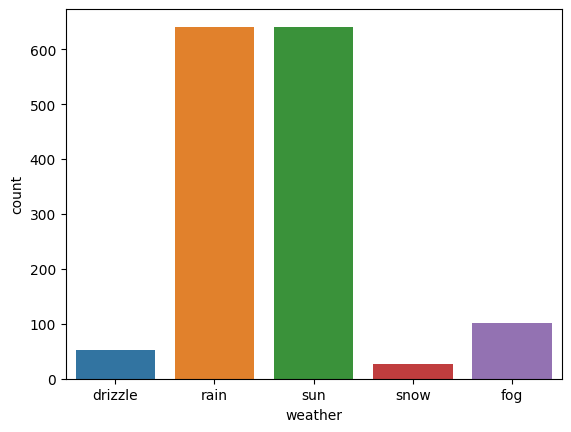

In [6]:
sns.countplot(data=df,x="weather")
plt.show();

## Define data and labels

In [7]:
X = df.drop("weather",axis=1)
y = df["weather"]

## Check for Constant features

In [8]:
sel = VarianceThreshold(threshold=0.01)
sel.fit(X)
features_to_drop = X.columns[~sel.get_support()]
print(f"Constant and Quasi-constant features: {features_to_drop.values}")

Constant and Quasi-constant features: []


## Check for duplicated features

In [9]:
duplicated_feat = []
for i in range(0,len(X.columns)):

    col_1 = X.columns[i]
    for col_2 in X.columns[i+1:]:
        if X[col_1].equals(X[col_2]):
            duplicated_feat.append(col_2)

print(f"Duplicated features: {duplicated_feat}")

Duplicated features: []


## Check for correlated features

In [10]:
def correlation(dataset, threshold=0.8):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

corr_features = correlation(X,0.8)
print(f"Correlated Features: {corr_features}")

Correlated Features: {'quarter', 'temp_min', 'day_of_year'}


In [11]:
X = X.drop(corr_features,axis=1)
X.head()

,precipitation,temp_max,wind,year,month,day
date,,,,,,
2012-01-01,0.0,12.8,4.7,2012,1,1
2012-01-02,10.9,10.6,4.5,2012,1,2
2012-01-03,0.8,11.7,2.3,2012,1,3
2012-01-04,20.3,12.2,4.7,2012,1,4
2012-01-05,1.3,8.9,6.1,2012,1,5


## Labelencoder

In [12]:
le = LabelEncoder()
y = le.fit_transform(y)

## Compute class weight

In [13]:
classes = np.unique(y)

classweight = compute_class_weight(class_weight="balanced",classes=classes,y=y)

classweight_dict = {}
for idx,weight in enumerate(classweight):
    classweight_dict[idx] = weight

classweight_dict

{0: 5.513207547169811,
 1: 2.893069306930693,
 2: 0.45585023400936037,
 3: 11.238461538461538,
 4: 0.4565625}

## Split data in train and test

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=49, stratify=y)

## Scale data

In [15]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Model selection and training

In [16]:
model = GradientBoostingClassifier()

params = {
    "learning_rate": [0.01,0.1,1],
    "n_estimators": [600],
    "max_depth": [2,3,5],
#     "class_weight": [classweight_dict],
    "random_state": [49]
}

grid = GridSearchCV(estimator=model,param_grid=params,cv=5,scoring="f1",verbose=1)
grid.fit(X_train,y_train)

best_model = grid.best_estimator_
best_params = grid.best_params_
print(f"Best parameters: {best_params}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 600, 'random_state': 49}


## Predict on test set

In [17]:
y_pred = best_model.predict(X_test)

In [18]:
y_pred = le.inverse_transform(y_pred)
y_test = le.inverse_transform(y_test)

## Check accuracy, recall, precision and F1

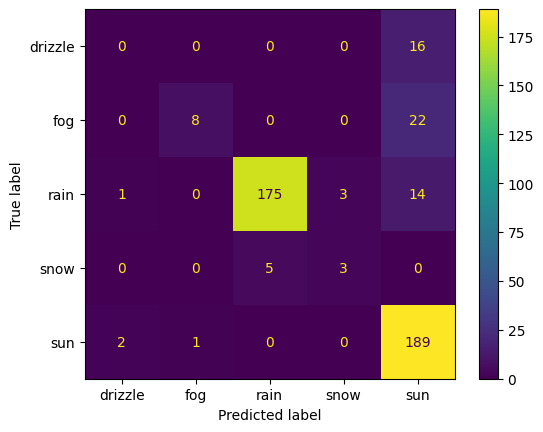

In [19]:
ConfusionMatrixDisplay.from_predictions(y_test,y_pred);

In [20]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

     drizzle       0.00      0.00      0.00        16
         fog       0.89      0.27      0.41        30
        rain       0.97      0.91      0.94       193
        snow       0.50      0.38      0.43         8
         sun       0.78      0.98      0.87       192

    accuracy                           0.85       439
   macro avg       0.63      0.51      0.53       439
weighted avg       0.84      0.85      0.83       439

